# Chapter 6: Summarization

## The CNN/DailyMail Dataset

* ~300k pairs of news articles and their corresponding summaries
* summaries are _abstractive_
* [`cnn_dailymail` dataset viewer at HF](https://huggingface.co/datasets/viewer/?dataset=cnn_dailymail&config=3.0.0)
* also see the [Dataset card for `cnn_dailymail` at HF](https://huggingface.co/datasets/cnn_dailymail)

In [1]:
from datasets import load_dataset

dataset = load_dataset(
    "cnn_dailymail",
    version="3.0.0"
)

print(f"Features: {dataset['train'].column_names}")

Found cached dataset cnn_dailymail (/home/kashiwapoodle/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['article', 'highlights', 'id']


In [2]:
sample = dataset["train"][1]

print(f"""
Article (excerpt of 500 char, total length: {len(sample['article'])}):""")
print(sample["article"][:500])
print(f"\nSummary (length: {len(sample['highlights'])}):")
print(sample["highlights"])


Article (excerpt of 500 char, total length: 4051):
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


In [3]:
import matplotlib.pyplot as plt

## Text Summarization Pipelines

This section require `nltk`, so be sure to download/install that before going any further.

In [4]:
sample_text = dataset["train"][1]["article"][:2000]

summaries = {}

In [5]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/kashiwapoodle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization.']

## Summarization Baseline

In [6]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

summaries["baseline"] = three_sentence_summary(sample_text)

In [7]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."'}

## GPT-2

> Large language models have a range of beneficial uses: they can assist in prose, poetry, and programming; analyze dataset biases; and more. However, their flexibility and generative capabilities also raise misuse concerns. This report discusses OpenAI's work related to the release of its GPT-2 language model. It discusses staged release, which allows time between model releases to conduct risk and benefit analyses as model sizes increased. It also discusses ongoing partnership-based research and provides recommendations for better coordination and responsible publication in AI. 

* Read ["Release Strategies and the Social Impacts of Language Models" by Solaiman, Brundage, Clark, Askell, Herbert-Voss, Wu, Radford, Krueger, Kim, Kreps, McCain, Newhouse, Blazakis, McGuffie, and Wang on arXiv](https://arxiv.org/ftp/arxiv/papers/1908/1908.09203.pdf).
* See the [`gpt2-xl` model details on HF](https://huggingface.co/gpt2-xl#model-details).

In [8]:
from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(
    gpt2_query,
    max_length=512,
    clean_up_tokenization_spaces=True
)
summaries["gpt2"] = "\n".join(sent_tokenize(pipe_out[0]['generated_text'][len(gpt2_query):]))

/opt/conda/envs/transformers-py38/lib/python3.8/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


## T5

Text-To-Text Transfer Transformer...

> Transfer learning, where a model is first pre-trained on a data-rich task before being fine-tuned on a downstream task, has emerged as a powerful technique in natural language processing (NLP). The effectiveness of transfer learning has given rise to a diversity of approaches, methodology, and practice. In this paper, we explore the landscape of transfer learning techniques for NLP by introducing a unified framework that converts all text-based language problems into a text-to-text format. Our systematic study compares pre-training objectives, architectures, unlabeled data sets, transfer approaches, and other factors on dozens of language understanding tasks. By combining the insights from our exploration with scale and our new "Colossal Clean Crawled Corpus", we achieve state-of-the-art results on many benchmarks covering summarization, question answering, text classification, and more. To facilitate future work on transfer learning for NLP, we release our data set, pre-trained models, and code. 

* Read ["Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer" by Raffel, Shazeer, Roberts, Lee, Narang, Matena, Zhou, Li, and Liu on arXiv](https://arxiv.org/pdf/1910.10683).
* See the [`tf-large` model details on HF](https://huggingface.co/t5-large#model-details).
* [`google-research/text-to-text-transfer-transformer`](https://github.com/google-research/text-to-text-transfer-transformer) on Github

In [9]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]['summary_text']))

/opt/conda/envs/transformers-py38/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


## BART

> ... BART, a denoising autoencoder for pretraining sequence-to-sequence models. BART is trained by (1) corrupting text with an arbitrary noising function, and (2) learning a model to reconstruct the original text. It uses a standard Tranformer-based neural machine translation architecture which, despite its simplicity, can be seen as generalizing BERT (due to the bidirectional encoder), GPT (with the left-to-right decoder), and many other more recent pretraining schemes. We evaluate a number of noising approaches, finding the best performance by both randomly shuffling the order of the original sentences and using a novel in-filling scheme, where spans of text are replaced with a single mask token. BART is particularly effective when fine tuned for text generation but also works well for comprehension tasks. It matches the performance of RoBERTa with comparable training resources on GLUE and SQuAD, achieves new state-of-the-art results on a range of abstractive dialogue, question answering, and summarization tasks, with gains of up to 6 ROUGE. BART also provides a 1.1 BLEU increase over a back-translation system for machine translation, with only target language pretraining. We also report ablation experiments that replicate other pretraining schemes within the BART framework, to better measure which factors most influence end-task performance. 

* Read ["BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension" by Lewis, Liu, Goyal, Ghazvininejad, Mohamed, Levy, Stoyanov, and Zettlemoyer on arXiv](https://arxiv.org/pdf/1910.13461.pdf).
* See the [`facebook/bart-large-cnn` model card on HF](https://huggingface.co/facebook/bart-large-cnn).

In [10]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]['summary_text']))

## PEGASUS

> Recent work pre-training Transformers with self-supervised objectives on large text corpora has shown great success when fine-tuned on downstream NLP tasks including text summarization. However, pre-training objectives tailored for abstractive text summarization have not been explored. Furthermore there is a lack of systematic evaluation across diverse domains. In this work, we propose pre-training large Transformer-based encoder-decoder models on massive text corpora with a new self-supervised objective. In PEGASUS, important sentences are removed/masked from an input document and are generated together as one output sequence from the remaining sentences, similar to an extractive summary. We evaluated our best PEGASUS model on 12 downstream summarization tasks spanning news, science, stories, instructions, emails, patents, and legislative bills. Experiments demonstrate it achieves state-of-the-art performance on all 12 downstream datasets measured by ROUGE scores. Our model also shows surprising performance on low-resource summarization, surpassing previous state-of-the-art results on 6 datasets with only 1000 examples. Finally we validated our results using human evaluation and show that our model summaries achieve human performance on multiple datasets. 

* Read ["PEGASUS: Pre-training with Extracted Gap-sentences for Abstractive Summarization" by Zhang, Zhao, Saleh and Liu on arXiv](https://arxiv.org/pdf/1912.08777.pdf).
* See the model card for [`google/pegasus-cnn_dailymail`](https://huggingface.co/google/pegasus-cnn_dailymail) on HF

<span style="background-color: #9AFEFF">This model has a dependency on the `protobuf` library, so you will need to `pip install` that as well!</span>

In [11]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace("<n>", "\n").replace(" .", ".")

## Comparing Different Summaries

In [12]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2
- No shoes.
- No bed.
- No mattress.
- Some inmates sleeping on the floor.
- Lacks security.
- Insufficient funds to provide mental health care.

T5
mentally ill inmates are housed on the ninth floor of a florida jail 

## Measuring the Quality of Generated Text

### BLEU

> _The closer a machine translation is to a professional human translation, the better it is._

* The BLEU metric is based primarily on [_precision_](https://en.wikipedia.org/wiki/Positive_and_negative_predictive_valueshttps://en.wikipedia.org/wiki/Positive_and_negative_predictive_values)<p/>
* It only really pays attention to how many n-grams in the _references_ (hopefully human-generated examples of good translations) show up in the translation (generated text).</p>
* It takes the geometric mean of precision calculated with respect to several n-grams, usually 1-grams through 4-grams. <p/><p/><span style="padding-left:1.5em">e.g., $p_{n} = \frac{\sum_{\text{n-gram } \in \text{ reference}} \underset{clip}{\text{Count(n-gram)}}}{ \sum_{\text{n-gram } \in \text{ translation}} \text{Count(n-gram)}}$</span><br/><br/><span style="padding-left:1.5em">and so $\text{BLEU-4} \sim \sqrt[4]{p_{1} \cdot p_{2} \cdot p_{3} \cdot p_{4}}$</span><p/>
* It also penalizes shorter translations by scaling the above-mentioned geometric mean of the n-grams with a brevity penalty ranging from `0.0` to `1.0`.<br/><span style="padding-left:1.5em">e.g., $\text{BP} = \begin{cases} 1 & \text{ if } c \gt r \\ e^{1 - \frac{r}{c}} & \text{ if } c \leq r \end{cases}$</span><br/>where $r$ is the effective reference corpus length and $c$ is the length of the candidate translation.<p/>
* Putting it all together, we have: <p/><p/><span style="padding-left:1.5em">$\text{BLEU-N} = \text{BP} \times \left( \prod_{n=1}^{N} p_{n} \right)^{\frac{1}{N}} $</span><p/>
* Plain-vanilla BLEU assumes that the translation and reference sentences are already tokenized, with the tokenization corresponding to single words. But different models may use different tokenization schemes, so that is why `sacrebleu` is currently preferred over `bleu`. For that reason, it is also the case that `bleu`/`sacrebleu` might not work very well with non-English languages, where tokenization may be happening at the morpheme-level.

References:
* Lewis in the [What is the BLEU metric? video on Youtube](https://www.youtube.com/watch?v=M05L1DhFqcw).
* [BLEU: a Method for Automatic Evaluation of Machine Translation](https://aclanthology.org/P02-1040.pdf)... only 8 pages!
* [Rachel Tatman's blogpost _Evaluating Text Output in NLP: BLEU at your own risk_](https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213)... ?


Regarding `datasets` and the `load_metric` API...

> <pre>FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate</pre>

<span style="background-color: #9AFEFF">This metric implementation has a dependency on the `sacrebleu` library, so you will need to `pip install` that as well!</span>

So we will go ahead and use the [`evaluate`](https://huggingface.co/evaluate-metric) API here.

In [13]:
import evaluate

In [14]:
new_bleu = evaluate.load("bleu")

predictions = ["I have thirty six years"]
references = [["I am thirty six years old", "I am thirty six"]]

new_bleu.compute(
    predictions=predictions,
    references=references
)

{'bleu': 0.0,
 'precisions': [0.8, 0.5, 0.3333333333333333, 0.0],
 'brevity_penalty': 1.0,
 'length_ratio': 1.25,
 'translation_length': 5,
 'reference_length': 4}

In [15]:
new_sacrebleu = evaluate.load("sacrebleu")

predictions = ["I have thirty six years"]
references = [["I am thirty six years old", "I am thirty six"]]

new_sacrebleu.compute(
    predictions=predictions,
    references=references,
    smooth_method="floor",
    smooth_value=0
)

{'score': 0.0,
 'counts': [4, 2, 1, 0],
 'totals': [5, 4, 3, 2],
 'precisions': [80.0, 50.0, 33.333333333333336, 0.0],
 'bp': 1.0,
 'sys_len': 5,
 'ref_len': 4}

### BLEU (`sacrebleu`, actually) via the `evaluate` API 

#### Inputs

* `predictions`: list of translations to score
* `references`: list of lists of references
* `smooth_method`: defaults to `exp` exponential decay; choose from `none`, `floor`, `add-k`, or `exp`
* `smooth_value`: `float`
* `tokenize`: tokenization method!
* `lowercase`: enable/disable case-insensitivity; defaults to `False`
* `force`: assume input is actually detokenized; defaults to `False`
* `use_effective_order`: flag to stop inclusion of n-gram orders for which precision is `0`, so use `True` for sentence-level BLEU computations; defaults to `False`

#### Outputs

* `score`: BLEU score, ranging from `0.0` to `100.0`, inclusive
* `counts`: Counts
* `totals`: Totals
* `precisions`: Precisions
* `bp`: Brevity penalty
* `sys_len`: predictions length
* `ref_len`: reference length


In [16]:
import pandas as pd
import numpy as np

predictions = ["the the the the the the"]
references = [["the cat is on the mat"]]

results = new_sacrebleu.compute(
    predictions=predictions,
    references=references,
    smooth_method="floor",
    smooth_value=0
)
results["precisions"] = [np.round(p,2) for p in results["precisions"]]

pd.DataFrame.from_dict(
    results,
    orient="index",
    columns=["value"]
)

,value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [17]:
predictions = ["the cat is on mat"]
references = [["the cat is on the mat"]]

results = new_sacrebleu.compute(
    predictions=predictions,
    references=references,
    smooth_method="floor",
    smooth_value=0
)
results["precisions"] = [np.round(p,2) for p in results["precisions"]]

pd.DataFrame.from_dict(
    results,
    orient="index",
    columns=["value"]
)

,value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### ROUGE

> The ROUGE score was specifically developed for applications like summarization where high [_recall_](https://en.wikipedia.org/wiki/Sensitivity_and_specificityhttps://en.wikipedia.org/wiki/Sensitivity_and_specificity) is more important than just precision.

References:
* Lewis in the [What is the ROUGE metric? video on Youtube](https://www.youtube.com/watch?v=TMshhnrEXlg)
* [ROUGE: A Package for Automatic Evaluation of Summaries](https://aclanthology.org/W04-1013.pdf)... again, only 8 pages!


<span style="background-color: #9AFEFF">This metric implementation has a dependency on the `absl-py` and `rouge_score` libraries, so you will need to `pip install rouge_score` as well!</span>

In [18]:
# let's use the rouge metric implementation in evaluate!
rouge = evaluate.load("rouge")

In [19]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [20]:
for model_name in summaries:
    results = rouge.compute(
        predictions=[summaries[model_name]],
        references=[reference]
    )
    records.append(results)
    
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.114286,0.029412,0.114286,0.114286
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.326531,0.208333,0.285714,0.326531


## Evaluating PEGASUS on the CNN/DailyMail Dataset

In [21]:
def evaluate_summaries_baseline(
    dataset,
    metric,
    column_text="article",
    column_summary="highlights"
):
    summaries = [
        three_sentence_summary(text) 
        for text in dataset[column_text]
    ]

    score = metric.compute(
        predictions=summaries,
        references=dataset[column_summary]
    )

    return score

In [22]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(
    test_sampled,
    rouge
)
#rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(
    score, 
    orient="index", 
    columns=["baseline"]
).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [23]:
from tqdm.notebook import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """ 
    Iterate and yield successive batch-sized chunks from list_of_elements.
    """
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i: i+batch_size]

def evaluate_summaries_pegasus(
    dataset,
    metric,
    model,
    tokenizer,
    batch_size=16,
    device=device,
    column_text="article",
    column_summary="highlights"
):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    num_batches = len(article_batches)
    
    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches),
        total=num_batches
    ):
        inputs = tokenizer(
            article_batch,
            max_length=1024,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        
        summaries = model.generate(
            input_ids=inputs["input_ids"].to(device),
            attention_mask=inputs["attention_mask"].to(device),
            length_penalty=0.8,
            num_beams=8,
            max_length=128
        )
        
        decoded_summaries = [
            tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for s in summaries
        ]
        
        decoded_summaries = [
            d.replace("<n>", " ")
            for d in decoded_summaries
        ]
        
        metric.add_batch(
            predictions=decoded_summaries,
            references=target_batch
        )
    
    score = metric.compute()
    return score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

score = evaluate_summaries_pegasus(
    test_sampled,
    rouge,
    model,
    tokenizer, 
    batch_size=8
)

#rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(score, index=["pegasus"])

  0%|          | 0/125 [00:00<?, ?it/s]

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434473,0.216573,0.311855,0.374261


## Training a Summarization Model

> The SAMSum dataset contains about 16k messenger-like conversations with summaries. Conversations were created and written down by linguists fluent in English. Linguists were asked to create conversations similar to those they write on a daily basis, reflecting the proportion of topics of their real-life messenger convesations. The style and register are diversified - conversations could be informal, semi-formal or formal, they may contain slang words, emoticons and typos. Then, the conversations were annotated with summaries. It was assumed that summaries should be a concise brief of what people talked about in the conversation in third person. The SAMSum dataset was prepared by Samsung R&D Institute Poland and is distributed for research purposes (non-commercial licence: CC BY-NC-ND 4.0).

* See the [dataset card for the SAMSum dataset](https://huggingface.co/datasets/samsum#dataset-card-for-samsum-corpus) on HF

<span style="background-color: #9AFEFF">The SAMSum dataset has a dependency on the `py7zr` library, so you will need to `pip install` that as well!</span>

In [25]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


### Evaluating PEGASUS on SAMSum

In [26]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [27]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"],
    rouge,
    model,
    tokenizer,
    column_text="dialogue",
    column_summary="summary",
    batch_size=8
)

pd.DataFrame(score, index=["pegasus"])

  0%|          | 0/103 [00:00<?, ?it/s]

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.29492,0.087419,0.228534,0.228906


### Fine-Tuning PEGASUS

Let's compare the dialogue and summary token lengths of the SAMSum dataset with the article and highlights token lengths of the CNN/DailyMail dataset.

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


<function matplotlib.pyplot.show(close=None, block=None)>

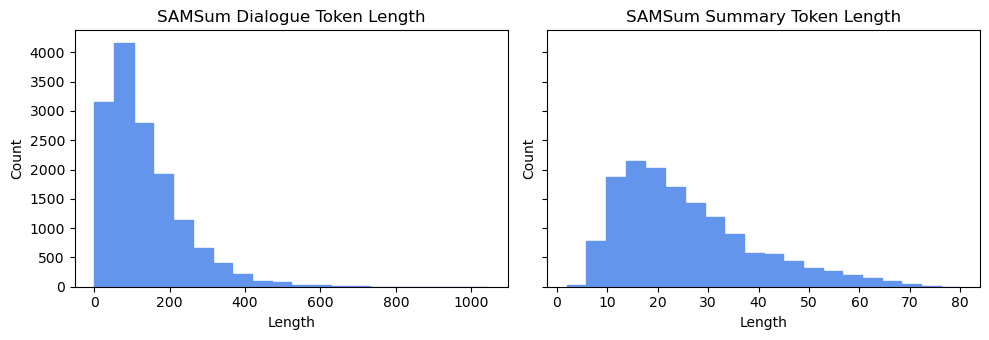

In [28]:
d_len = [
    len(tokenizer.encode(s))
    for s in dataset_samsum["train"]["dialogue"]
]
s_len = [
    len(tokenizer.encode(s))
    for s in dataset_samsum["train"]["summary"]
]

color = "cornflowerblue"

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)

axes[0].hist(d_len, bins=20, color=color, edgecolor=color)
axes[0].set_title("SAMSum Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(s_len, bins=20, color=color, edgecolor=color)
axes[1].set_title("SAMSum Summary Token Length")
axes[1].set_xlabel("Length")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

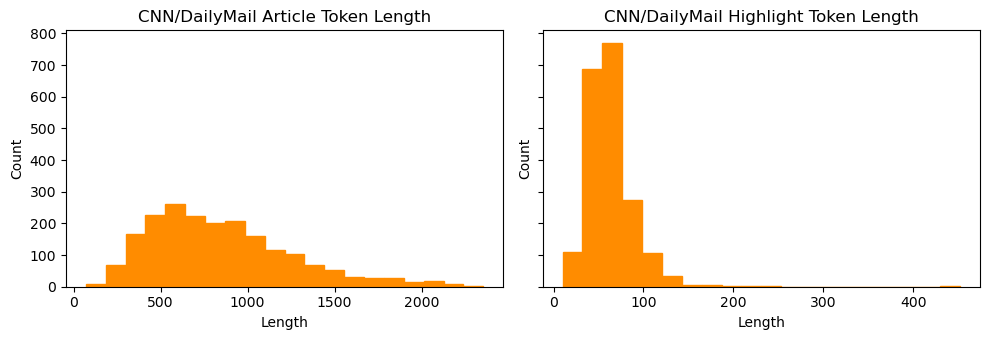

In [29]:
# keep things sane, let's just take a 2000-element sample
# so that we can quickly compare CNN/DailyMail vs SAMSum
dataset_sample = dataset["train"].shuffle(seed=42)[:2000]

a_len = [
    len(tokenizer.encode(s))
    for s in dataset_sample["article"]
]
h_len = [
    len(tokenizer.encode(s))
    for s in dataset_sample["highlights"]
]

color = "darkorange"

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)

axes[0].hist(a_len, bins=20, color=color, edgecolor=color)
axes[0].set_title("CNN/DailyMail Article Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(h_len, bins=20, color=color, edgecolor=color)
axes[1].set_title("CNN/DailyMail Highlight Token Length")
axes[1].set_xlabel("Length")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show

----

In [30]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(
        example_batch["dialogue"],
        max_length=1024,
        truncation=True
    )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(
            example_batch["summary"],
            max_length=128,
            truncation=True
        )

    return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"]
    }

dataset_samsum_pt = dataset_samsum.map(
    convert_examples_to_features, 
    batched=True
)

columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

##### Set up a `DataCollator`

In [31]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model
)

##### Set up `TrainingArguments`

See `output_dir`? You may need to visit [Create a new model repository](https://huggingface.co/new) on HF whilst logged in in order to create the model repo before executing the next set of code blocks.

In [32]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="pegasus-samsum",
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    push_to_hub=True,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16,
    optim="adamw_torch"    # let's get rid of that annoying warning message
)

Use your Notebook Token here!

In [33]:
from huggingface_hub import notebook_login

notebook_login()

In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=seq2seq_data_collator,
    train_dataset=dataset_samsum_pt["train"],
    eval_dataset=dataset_samsum_pt["validation"]
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/kashiwapoodle/dev/github/transformers-gcp/pegasus-samsum is already a clone of https://huggingface.co/buruzaemon/pegasus-samsum. Make sure you pull the latest changes with `repo.git_pull()`.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [35]:
trainer.train()

score = evaluate_summaries_pegasus(
    dataset_samsum["test"],
    rouge,
    trainer.model,
    tokenizer,
    batch_size=2,
    column_text="dialogue",
    column_summary="summary"
)

pd.DataFrame(score, index=["pegasus"])

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,1.700300,1.485591


  0%|          | 0/410 [00:00<?, ?it/s]

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.431741,0.203297,0.343514,0.343701


In [36]:
trainer.push_to_hub(commit_message="Training completed!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/buruzaemon/pegasus-samsum
   bb00d59..041a511  main -> main

   bb00d59..041a511  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

'https://huggingface.co/buruzaemon/pegasus-samsum/commit/041a5117781eaa53ab1ff0a376fb8d8fd4e0d61a'

## Generating Dialogue Summaries

In [37]:
gen_kwargs = { 
    "length_penalty": 0.8,
    "num_beams": 8,
    "max_length": 128
}

In [38]:
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry instead of calling Betty.


In [39]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?
Thom: I am in!
Lewis: Awesome, let's do it together!
"""

print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but you input_length is only 91. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Thom, Lewis and Leandro are going to write a book about transformers. Thom helped build a library by Hugging Face. They are going to do it together.
